# Lab 5: Spam Detection

**Deadline**: Monday, July 18 at 5:00 PM

**Late Penalty**: Any work that is submitted between 0 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Justin Beland <justin.beland@mail.utoronto.ca>

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: [https://colab.research.google.com/drive/1wDQ2FnBNXvbDHc8fHnBqjYxSMTPLq-HJ?usp=sharing](https://colab.research.google.com/drive/1wDQ2FnBNXvbDHc8fHnBqjYxSMTPLq-HJ?usp=sharing)


In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
from tqdm.auto import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [2]:
print_ham = False
print_spam = False
for line in open('SMSSpamCollection'):
    if int(print_spam)*int(print_ham) ==1:
        break
    message = line.split("\t",1)
    if message[0] == "ham" and not print_ham:
        print_ham = True
        print("########################")
        print("example of non-spam SMS:\n{}".format(message[1]))
    elif message[0] == "spam" and not print_spam:
        print_spam = True
        print("########################")
        print("example of spam SMS:\n{}".format(message[1]))

########################
example of non-spam SMS:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

########################
example of spam SMS:
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [3]:
ham = 0
spam = 0
for line in open('SMSSpamCollection'):

    message = line.split("\t",1)
    if message[0] == "ham":
        ham += 1
    elif message[0] == "spam":
        spam += 1

print("# spam: {}\n# ham: {}".format(spam,ham))

# spam: 747
# ham: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.



---
**Advantages**


*   Smaller volcabulary (26 numbers + 10 numbers compared to thousands of unique words) thus less memory is required
*   Can recognize mis-spelling of vocabularies (which include obvious typo and will be labelled as "unknown token" with word-level RNN)

---

**Disadvantages**


*   Each individual letter is treated as a single token, thus larger network hidden layers are required for the same sample. Therefore, it is more computationally intensive for character-level RNN to achieve the same learning task (such as semantics generation, syntax identification, etc.) with word-level RNN.
*   character-level RNN has lower accuracy than the word-level RNN

---

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [4]:
# %pip install torchtext==0.9

In [5]:
#  pip install torchtext==0.9
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label
train, valid, test = dataset.split([0.6, 0.2, 0.2], random_state = np.random.seed(100))
print("train #: {}\nvalid #: {}\ntest #: {}".format(len(train), len(valid), len(test)))

train #: 3343
valid #: 1115
test #: 1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

---

Having a balanced training set will produce equal probability for model's prediction of `ham` or `spam` . If no duplication of the training data is included, the model is encouraged to predict more `ham` label than `spam` label. For example, if the model blindly predict `ham` for all given examples, the overall training accuracy will still achieve 86.6%.


---

In [6]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [7]:
text_field.build_vocab(train)
print("============== STOI ===============")
print(text_field.vocab.stoi)
print("\n============== ITOS ===============")
print(text_field.vocab.itos)

============== STOI ===============
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x000001B30A897820>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'm': 17, 'c': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, '8': 27, 'T': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'C': 33, 'S': 34, 'I': 35, 'O': 36, '7': 37, '4': 38, 'N': 39, 'x': 40, 'A': 41, '6': 42, '3': 43, 'R': 44, '!': 45, ',': 46, 'P': 47, '9': 48, 'M': 49, 'L': 50, 'W': 51, 'U': 52, 'H': 53, 'D': 54, 'F': 55, 'G': 56, 'B': 57, 'Y': 58, "'": 59, '?': 60, '/': 61, '£': 62, '&': 63, ':': 64, '-': 65, 'X': 66, 'V': 67, 'z': 68, 'j': 69, 'K': 70, '*': 71, 'J': 72, ')': 73, '+': 74, ';': 75, '"': 76, '(': 77, 'q': 78, 'Q': 79, '#': 80, '@': 81, '=': 82, '>': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '|': 87, '<': 88, '\x92': 89, '‘': 90, '$': 91, '_': 92, '%': 93, '¡': 94

- `text_field.vocab.stoi` returns an instance of `defaultdict` that maps all existing token character (in `str` form) to a unique integer label. **stoi** is a shorthand form for *string to integer*
- `text_field.vocab.itos` returns a list of token character ordered by their given integer label. **itos** is a shorthand form for *integer to string*

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

---
- `<unk> represents unknown tokens`
- `<pad>` represents paddings that are used to pad all training data to the same length (to maximum length of a batch).
---

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [8]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [9]:
count = 0
for batch in train_iter:
    if count >= 10:
        break
    else:
        pad = batch.sms[1][0] * len(batch.sms[1])
        for i in range(len(batch.sms[1])):
            pad -= batch.sms[1][i]
        print("batch {} - maximum length of input: {}\n# of pad tokens: {}".format(count, batch.sms[1][0], pad))

    count += 1

batch 0 - maximum length of input: 61
# of pad tokens: 36
batch 1 - maximum length of input: 147
# of pad tokens: 0
batch 2 - maximum length of input: 160
# of pad tokens: 0
batch 3 - maximum length of input: 157
# of pad tokens: 0
batch 4 - maximum length of input: 163
# of pad tokens: 23
batch 5 - maximum length of input: 79
# of pad tokens: 42
batch 6 - maximum length of input: 132
# of pad tokens: 45
batch 7 - maximum length of input: 51
# of pad tokens: 11
batch 8 - maximum length of input: 20
# of pad tokens: 88
batch 9 - maximum length of input: 158
# of pad tokens: 0


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [10]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [11]:
one_hot_size = len(text_field.vocab.itos)

In [12]:
class SpamDetection(nn.Module):
    def __init__(self, one_hot, hidden_size, num_classes):
        self.name = "SPAM_RNN"
        super(SpamDetection, self).__init__()
        self.emb = torch.eye(one_hot)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(one_hot, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(torch.max(out, dim=1)[0])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [13]:
def get_accuracy(model, iter):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    #
    # iter = torchtext.legacy.data.BucketIterator(data,
    #         batch_size=64,
    #         sort_key=lambda x: len(x.sms), # to minimize padding
    #         sort_within_batch=True,        # sort within each batch
    #         repeat=False)                  # repeat the iterator for many epochs

    correct, total = 0, 0
    for sms, labels in iter:
        output = model(sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total


### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [14]:
def get_model_name(name, batch_size, learning_rate, epoch, numhidden):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "./saved_model/model_{0}_bs{1}_lr{2}_hiddenu{3}_epoch{4}".format(name,
                                                                 batch_size,
                                                                 learning_rate,
                                                                 numhidden,
                                                                 epoch)
    return path


In [15]:
def train_acc(model, train_set, valid_set, batch_size=64, num_epochs=5, learning_rate=1e-4, numhidden = 100, use_cuda =True):
    """ Training loop. You should update this."""

    train_l = torchtext.legacy.data.BucketIterator(train_set,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
    valid_l = torchtext.legacy.data.BucketIterator(valid_set,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

    #################################################################
    # check if there exists a separate model folder exist for saving pretrained weight
    if not os.path.exists('./saved_model'):
        os.mkdir('./saved_model')

    #################################################################
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, loss_record, epoch_num, acc_record = [], [], [], []
    val_iter, val_loss, val_acc = [], [], []
    n = 0


    progress_total = num_epochs * (len(train_l)+ len(valid_l) )
    pbar = tqdm(desc = 'while loop', total = progress_total)


    for epoch in range(num_epochs):
        for imgs, labels in train_l:
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            out = model(imgs[0])
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            iters.append(n)
            loss_record.append(float(loss)/batch_size)
            n += 1
            pbar.update(1)
            # print("check")
        epoch_num.append(epoch)
        acc_record.append(get_accuracy(model, train_l))

        model_path = get_model_name(model.name, batch_size, learning_rate, epoch, numhidden)
        torch.save(model.state_dict(), model_path)

        ##################################################################
        val_l = 0
        for valimgs, vallabels in valid_l:
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              valimgs = valimgs.cuda()
              vallabels = vallabels.cuda()
            #############################################

            out = model(valimgs[0])
            loss = criterion(out, vallabels)
            optimizer.zero_grad()
            val_l += float(loss)/batch_size
            pbar.update(1)


        val_iter.append(n)
        val_loss.append(val_l/len(valid_l))
        val_acc.append(get_accuracy(model, valid_l))

    # plotting
    plt.title("Loss Training Curve")
    plt.plot(iters, loss_record, label="Train")
    plt.plot(val_iter, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy Training Curve")
    plt.plot(epoch_num, acc_record, label="Train")
    plt.plot(epoch_num, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(acc_record[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

***SEE FINAL MODEL TRAINING CURVE IN PART(C) - Hyperparameter set 7**

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

### Hyperparameter set 1: default

CUDA is not available.  Training on CPU ...



while loop:   0%|          | 0/3330 [00:00<?, ?it/s]

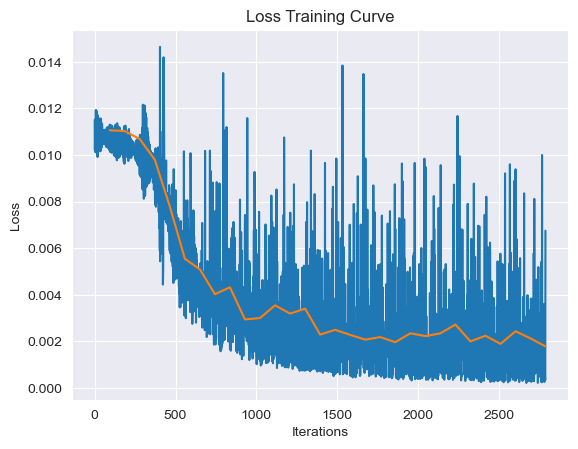

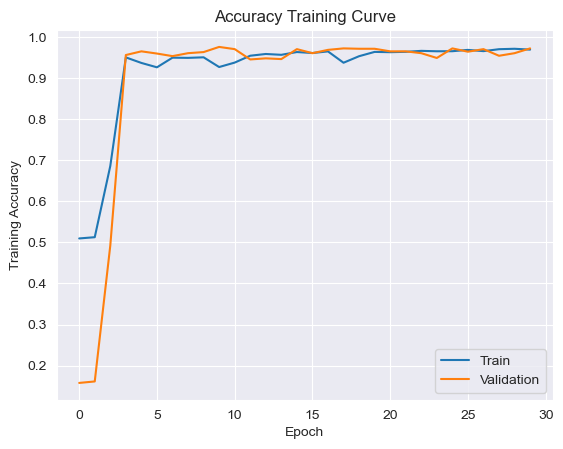

Final Training Accuracy: 0.9692411695115768
Final Validation Accuracy: 0.9721973094170404


In [31]:
################### HYPERPARAMETERS ###################
batch_size = 64
epoch_n = 30
learning_rate = 1e-4
hidden_n = 100
#######################################################

model = SpamDetection(one_hot_size, hidden_n, 2)
use_gpu =True
if use_gpu and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...\n')
else:
  print('CUDA is not available.  Training on CPU ...\n')

train_acc(model, train, valid, batch_size, epoch_n,learning_rate, hidden_n)

### Hyperparameter set 2: increased # of hidden units
Increased the number of hidden units to 200 to see if the curve will show overfitting trend

CUDA is not available.  Training on CPU ...



while loop:   0%|          | 0/3330 [00:00<?, ?it/s]

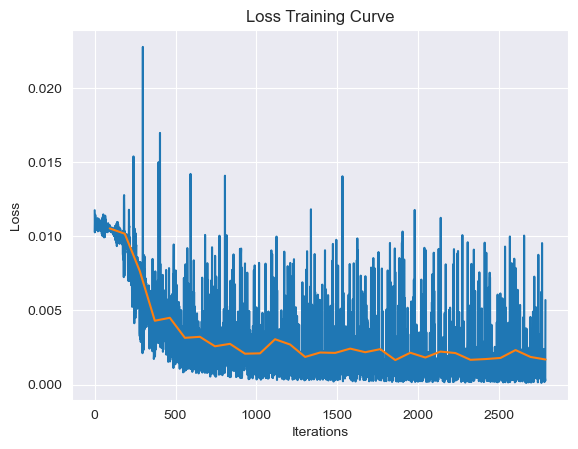

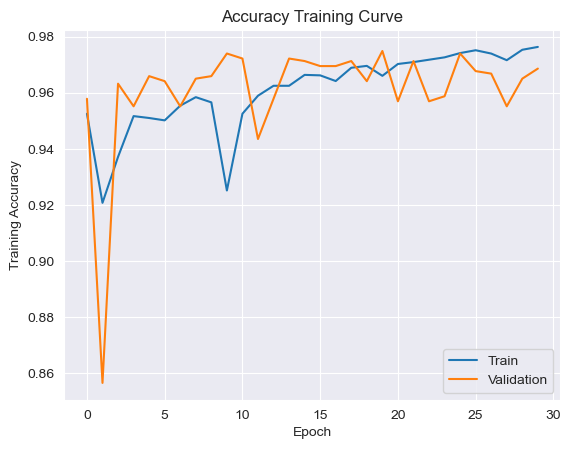

Final Training Accuracy: 0.9763393611627514
Final Validation Accuracy: 0.968609865470852


In [19]:
################### HYPERPARAMETERS ###################
batch_size = 64
epoch_n = 30
learning_rate = 1e-4
hidden_n = 200
#######################################################

model = SpamDetection(one_hot_size, hidden_n, 2)
use_gpu =True
if use_gpu and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...\n')
else:
  print('CUDA is not available.  Training on CPU ...\n')
train_acc(model, train, valid, batch_size, epoch_n,learning_rate, hidden_n)

### Hyperparameter set 3: increased learning rate
Increase the learning rate to enable the model to learn faster & explore a larger ranges of model parameters.


CUDA is not available.  Training on CPU ...



while loop:   0%|          | 0/3330 [00:00<?, ?it/s]

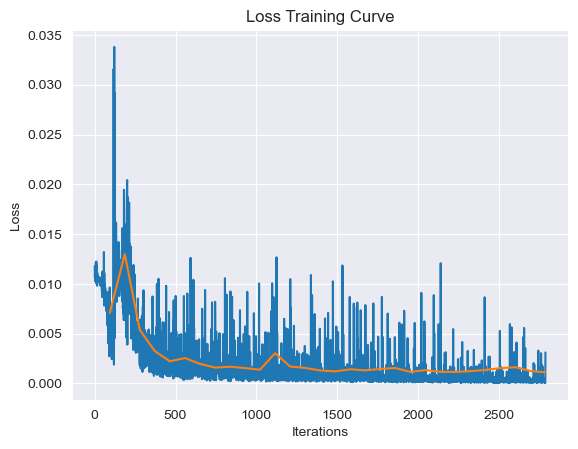

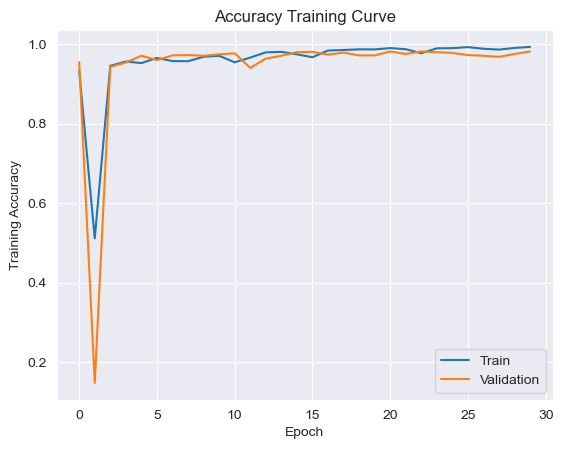

Final Training Accuracy: 0.9935778266013182
Final Validation Accuracy: 0.9820627802690582


In [25]:
################### HYPERPARAMETERS ###################
batch_size = 64
epoch_n = 30
learning_rate = 5e-4
hidden_n = 200
#######################################################


model = SpamDetection(one_hot_size, hidden_n, 2)
use_gpu =True
if use_gpu and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...\n')
else:
  print('CUDA is not available.  Training on CPU ...\n')
train_acc(model, train, valid, batch_size, epoch_n,learning_rate, hidden_n)

### Hyperparameter set 4: decreased batch size
Reduce the batch size to 32, as the train accuracy is always higher than the validation accuracy at the end of the learning curve (slight sign of overfitting)

CUDA is not available.  Training on CPU ...



while loop:   0%|          | 0/6600 [00:00<?, ?it/s]

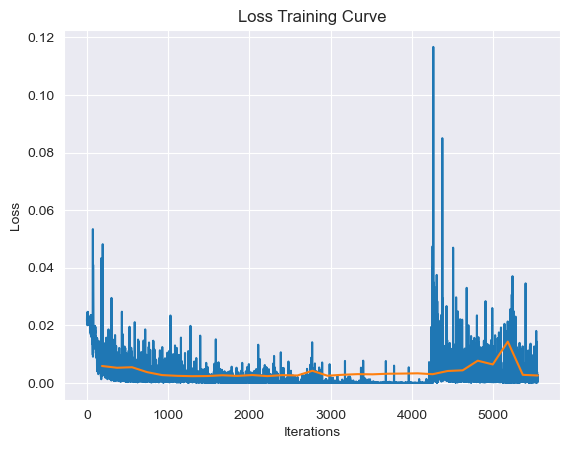

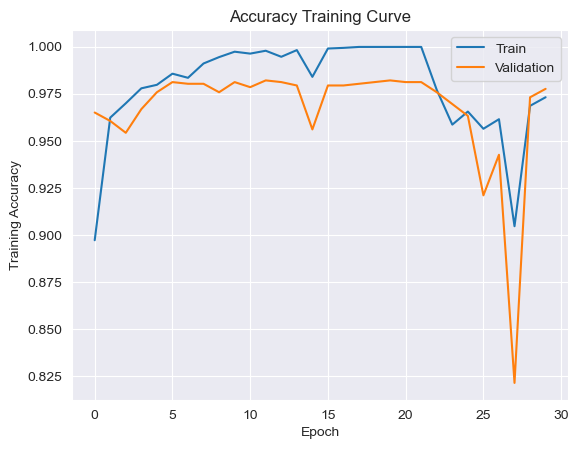

Final Training Accuracy: 0.9731282744634105
Final Validation Accuracy: 0.9775784753363229


In [27]:
################### HYPERPARAMETERS ###################
batch_size = 32
epoch_n = 30
learning_rate = 5e-4
hidden_n = 200
#######################################################

model = SpamDetection(one_hot_size, hidden_n, 2)
use_gpu =True
if use_gpu and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...\n')
else:
  print('CUDA is not available.  Training on CPU ...\n')
train_acc(model, train, valid, batch_size, epoch_n,learning_rate, hidden_n)

### Hyperparameter set 5: More epochs to train
Using the original batch size of 64, I reduced the learning rate and increased the number of epochs to train, thus can explore a large set of model parameters with smaller steps. As the model checkpoint is saved at the end of each epoch, we can choose the optimal set of parameters from looking at the learning curves.

CUDA is not available.  Training on CPU ...



while loop:   0%|          | 0/22200 [00:00<?, ?it/s]

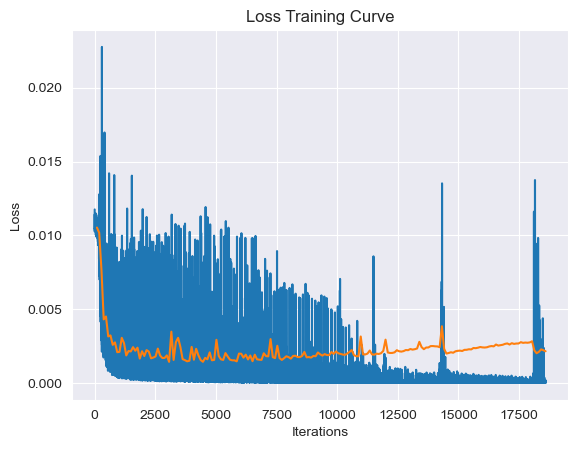

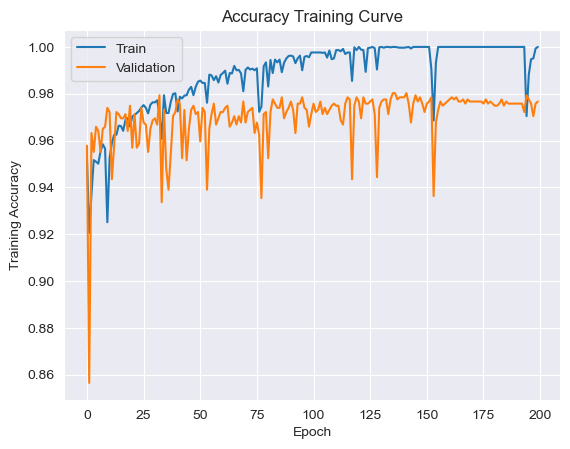

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9766816143497757


In [29]:
################### HYPERPARAMETERS ###################
batch_size = 64
epoch_n = 200
learning_rate = 1e-4
hidden_n = 200
#######################################################

model = SpamDetection(one_hot_size, hidden_n, 2)
use_gpu =True
if use_gpu and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...\n')
else:
  print('CUDA is not available.  Training on CPU ...\n')
train_acc(model, train, valid, batch_size, epoch_n,learning_rate, hidden_n)

### Hyperparameter set 6: RNN output pooling method changes

Using hyperparameter set 3 (the current model that outputs the best accuracy) and switches the network's pooling method to see if final output accuracy/loss can be improved.

In [16]:
class SpamDetection_1(nn.Module):
    def __init__(self, one_hot, hidden_size, num_classes):
        self.name = "SPAM_RNN_1"
        super(SpamDetection_1, self).__init__()
        self.emb = torch.eye(one_hot)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(one_hot, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        # out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        # out = self.fc(torch.max(out, dim=1)[0])
        return out

CUDA is not available.  Training on CPU ...



while loop:   0%|          | 0/3360 [00:00<?, ?it/s]

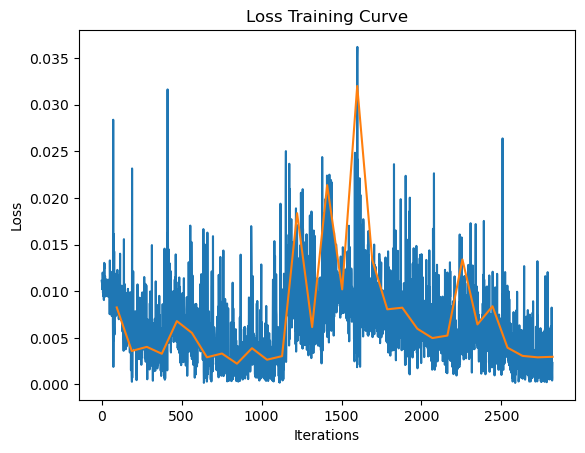

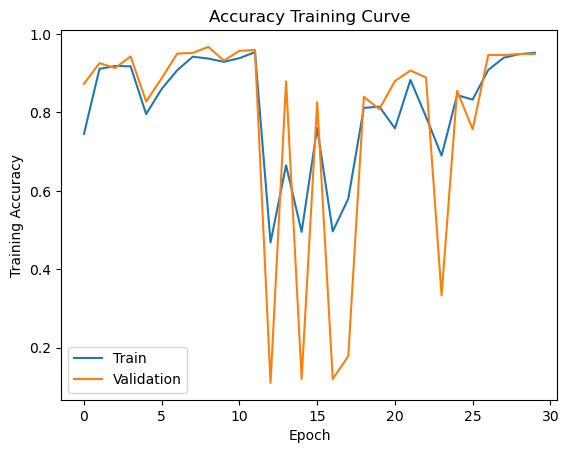

Final Training Accuracy: 0.9518894622939903
Final Validation Accuracy: 0.9488789237668162


In [17]:
################### HYPERPARAMETERS ###################
batch_size = 64
epoch_n = 30
learning_rate = 5e-4
hidden_n = 200
#######################################################


model = SpamDetection_1(one_hot_size, hidden_n, 2)
use_gpu =True
if use_gpu and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...\n')
else:
  print('CUDA is not available.  Training on CPU ...\n')
train_acc(model, train, valid, batch_size, epoch_n,learning_rate, hidden_n)

### Hyperparameter set 7: RNN output pooling method changes (USED AS THE FINAL SET)
Using hyperparameter set 3 (the current model that outputs the best accuracy) and switches the network's pooling method to concatenation to see if final output accuracy/loss can be improved.

This set of hyperparameter is used as the final model set as it produced the highest validation accuracy with no sign of training set overfitting

In [18]:
class SpamDetection_2(nn.Module):
    def __init__(self, one_hot, hidden_size, num_classes):
        self.name = "SPAM_RNN_2"
        super(SpamDetection_2, self).__init__()
        self.emb = torch.eye(one_hot)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(one_hot, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1))
        return out

CUDA is not available.  Training on CPU ...



while loop:   0%|          | 0/3360 [00:00<?, ?it/s]

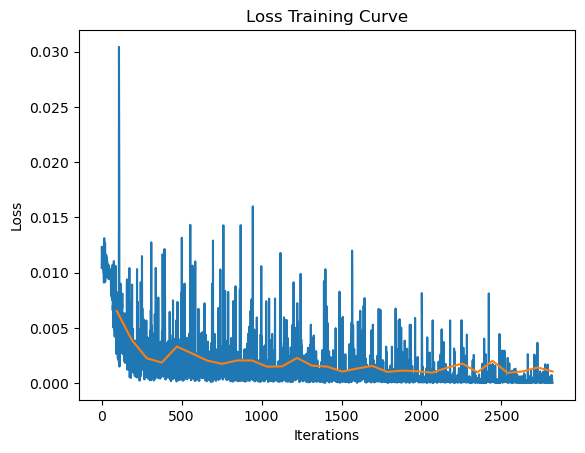

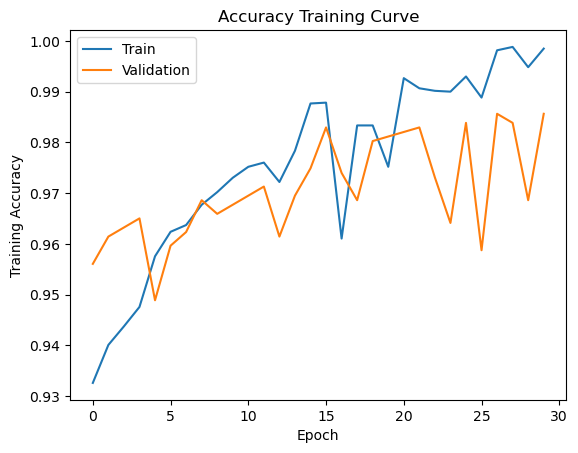

Final Training Accuracy: 0.9985017479607124
Final Validation Accuracy: 0.9856502242152466


In [19]:
################### HYPERPARAMETERS ###################
batch_size = 64
epoch_n = 30
learning_rate = 5e-4
hidden_n = 200
#######################################################


model = SpamDetection_2(one_hot_size, hidden_n, 2)
use_gpu =True
if use_gpu and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...\n')
else:
  print('CUDA is not available.  Training on CPU ...\n')
train_acc(model, train, valid, batch_size, epoch_n,learning_rate, hidden_n)

 ### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [20]:
net = SpamDetection_2(one_hot_size, 200, 2)
net.load_state_dict(torch.load('./saved_model/model_SPAM_RNN_2_bs64_lr0.0005_hiddenu200_epoch29'))

<All keys matched successfully>

In [21]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

valid_spam_loader = torchtext.legacy.data.BucketIterator(valid_spam,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

valid_nospam_loader = torchtext.legacy.data.BucketIterator(valid_nospam,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

false_pos = 1 - get_accuracy(net, valid_nospam_loader)
false_neg = 1 - get_accuracy(net, valid_spam_loader)

print("false positive %: {}\nfalse negative %: {}".format(false_pos,false_neg))

false positive %: 0.004094165813715467
false negative %: 0.08695652173913049


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

---

- false positive: Falsely identifies non-spam messages as spam and thus falsely blocking message. Users might miss some important message, such as delivery arrival, due to the false positive anti-spam detection.
- false negative: Falsely identifies spam messages as non-spam. In this case, users might see some SPAM messages that has gone through the anti-spam filters due to the false negative detection.

---


## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [24]:
test_l = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
print(get_accuracy(net, test_l))

0.9956373429084381


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [25]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

test_spam_loader = torchtext.legacy.data.BucketIterator(test_spam,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

test_nospam_loader = torchtext.legacy.data.BucketIterator(test_nospam,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

false_pos = 1 - get_accuracy(net, test_nospam_loader)
false_neg = 1 - get_accuracy(net, test_spam_loader)

print("false positive %: {}\nfalse negative %: {}".format(false_pos,false_neg))

false positive %: 0.005268703898840932
false negative %: 0.07272727272727275


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [26]:
msg = "machine learning is sooo cool!"

def SPAM_probability(msg, model):
    char_idx = [text_field.vocab.stoi[char] for char in msg]
    char_idx = torch.LongTensor([char_idx])
    pred = model(char_idx)
    m = nn.Softmax(dim=1)
    print("SPAM Probability for this msg is:", float(m(pred)[0][1]))

In [27]:
msg = "machine learning is sooo cool!"
SPAM_probability(msg, net)

SPAM Probability for this msg is: 0.009360275231301785


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Detecting spam is a difficult task.
We can use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering) as baseline for the spam detection algorithm.
1. first build up vocabulary count separately for all spam and non-spam messages, thus the probability of any word appear in spam/non-spam can be calculated by dividing the number of individual word occurrence in spam/non-spam by the total spam/non-spam message count.
2. Calculate the SPAM probability given an SMS message using the formula $p=\frac{p_1⋅p_2 ⋯ p_N}{p_1⋅p_2 ⋯ p_N + (1-p_1)(1-p_2)⋯(1-p_N)}$, where `p` is the probability that the inspected message is spam, `p1`, `p2` is the probability that the first/second word appears in spam...and`pN` is the probability that the Nth word appears in spam.
3. If p > 0.5, the message is likely to be a SPAM, and vice versa.